# Application: `JaxILI` to perform inference on Power Spectrum mock data from `jax_cosmo`

*Author: Sacha Guerrini*

In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import copy

#import libraries
import warnings
from tqdm import tqdm
from typing import Any, Sequence
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as stats
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import jax_cosmo as jc
import haiku as hk
import optuna
import optax

#Tensorflow import
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

#Torch import
import torch
import torch.utils.data as data

#JaxILI import
from jaxili.utils import create_data_loader
from jaxili.model import ConditionalRealNVP, ConditionalMAF, MixtureDensityNetwork
from jaxili.train import TrainerModule, TrainState

2024-03-06 16:09:22.777969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 16:09:22.777992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 16:09:22.778717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 16:09:23.543951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Simulation

In [2]:
cosmo = jc.Planck15() #Create a cosmology with default parameters
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [3]:
nz = jc.redshift.smail_nz(1., 2., 0.75, gals_per_arcmin2=6)
tracer = jc.probes.WeakLensing([nz])

fiducial_params = np.array([cosmo.Omega_c, cosmo.sigma8])

ell = jnp.logspace(2, np.log10(2000), 20)

#Compute the mean and covariance matrix for this cosology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)

In [4]:
#Let's build a simulator that returns a sample of Cl for a given cosmology
@jax.jit
def sample_likelihood(params, key):
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu = jc.angular_cl.angular_cl(cosmo, ell, [tracer]).flatten()
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=jnp.sqrt(jnp.diag(cov)))
    return dist.sample(seed=key)

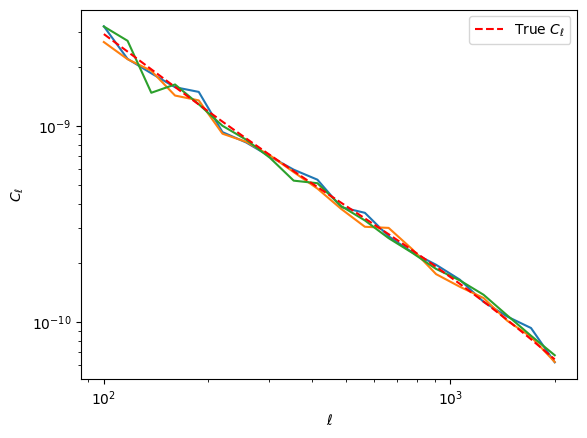

In [5]:
plt.figure()

plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(0)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(1)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(2)))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.loglog(ell, mu, color='red', linestyle='--', label="True $C_\ell$")
plt.legend()
plt.show()

In [6]:
seq = hk.PRNGSequence(42)

def simulator(theta):
    return sample_likelihood(theta, next(seq))

In [7]:
#Generate parameters
dim_params = 2
dim_obs = 20

def generate_thetas(n_samples, dim):
    thetas =  stats.qmc.LatinHypercube(d=dim).random(n_samples)
    thetas = stats.qmc.scale(thetas, np.array([0.1, 0.1]), np.array([1, 1]))
    return thetas

In [8]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
train_set_size = 5000
val_set_size = 1000
test_set_size = 2000

#Create the datasets
train_set = PowerSpectrumDataset(train_set_size, dim_params)
print("Train_set created")
val_set = PowerSpectrumDataset(val_set_size, dim_params)
print("Val_set created")
test_set = PowerSpectrumDataset(test_set_size, dim_params)
print("Test_set created")

#Specify the batch_size
batch_size = 128
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = 128
)

KeyboardInterrupt: 

In [ ]:
#Save datset
torch.save(train_set, 'ps_dataset/train_set.pt')
torch.save(val_set, 'ps_dataset/val_set.pt')
torch.save(test_set, 'ps_dataset/test_set.pt')

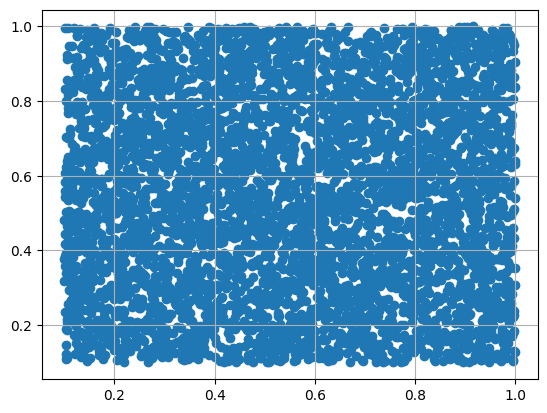

In [79]:
plt.figure()

plt.scatter(train_set.thetas[:, 0], train_set.thetas[:, 1], label="Train set")
plt.grid()
plt.show()

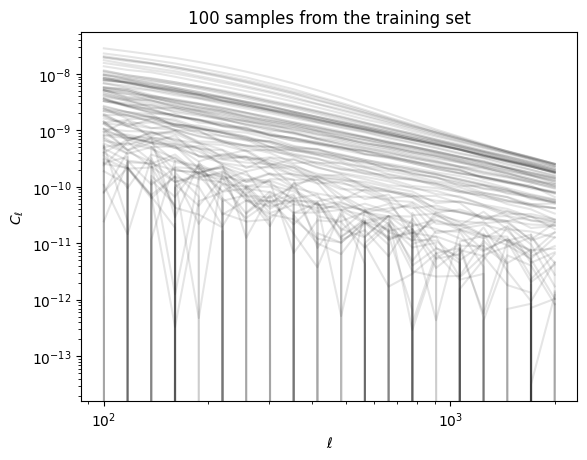

In [80]:
plt.figure()

for sim in train_set.xs[:100]:
    plt.loglog(ell, sim, color='black', alpha=0.1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("100 samples from the training set")
plt.show()


## Neural Posterior Estimation

In [9]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

train_set = torch.load('ps_dataset/train_set.pt')
val_set = torch.load('ps_dataset/val_set.pt')
test_set = torch.load('ps_dataset/test_set.pt')

#Specify the batch_size
batch_size = 50
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = batch_size
)

In [11]:
class MDNTrainer(TrainerModule):#Inherits from TrainerModule to use the training loop
    def __init__(self, #Overload __init__ with hyperparameters of the network
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        self.trial = trial

    def create_functions(self): #The user has to create this function to initialize the train_step and test_step.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
         pass
        
    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 prior : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                             'prior': prior
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  method='log_prob')
            return -jnp.mean(output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }
        self.config['model_hparams']['prior'] = 'Uniform'

    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def print_tabulate(self, exmp_input):
        pass

class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

In [13]:
import distrax

prior_normal = distrax.MultivariateNormalDiag(loc=0.5*jnp.ones(2), scale_diag=0.5*jnp.ones(2))

In [14]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/'

dim_params = 2
dim_obs = 20

trainer = MAFTrainer(
    n_in=dim_params,
    n_cond=dim_obs,
    n_layers=5,
    layers=[50, 50],
    use_reverse=False,
    seed=30,
    activation='relu',
    prior=prior_normal,
    optimizer_hparams={
        'lr': 5e-4,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

In [15]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, mu.reshape((-1, 20)), num_samples=10000, key=key, method='sample'
)

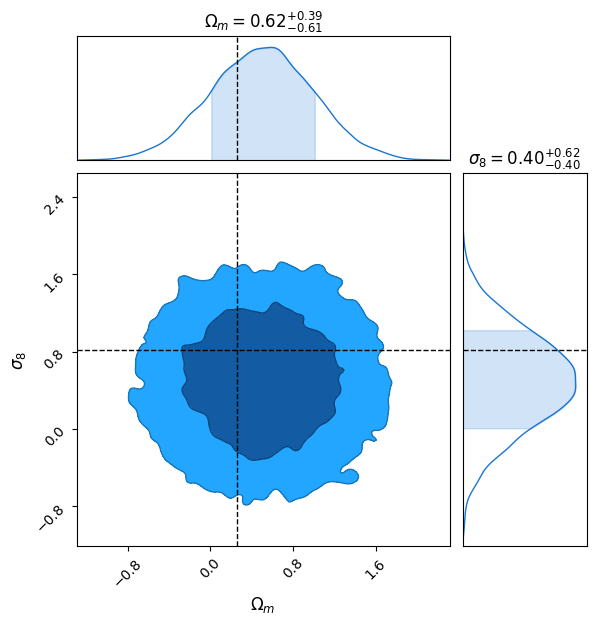

In [16]:
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()


In [17]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_1.orbax-checkpoint-tmp-1709738039844400 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_1
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_1`.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_2.orbax-checkpoint-tmp-1709738040148668 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_2
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_2`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_1


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_3.orbax-checkpoint-tmp-1709738040445799 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_4.orbax-checkpoint-tmp-1709738040720852 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_3


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_5.orbax-checkpoint-tmp-1709738041015518 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_5`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_4


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 6
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_6.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_6.orbax-checkpoint-tmp-1709738041297550 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_6
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_6`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 7
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_7.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_7.orbax-checkpoint-tmp-1709738041596449 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_7
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_7`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_6


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 8
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_8.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_8.orbax-checkpoint-tmp-1709738041899840 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_8
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_8`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_7


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 9
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_9.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_9.orbax-checkpoint-tmp-1709738042196181 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_9
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_9`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_8


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 11
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11.orbax-checkpoint-tmp-1709738042753328 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_9


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_17/checkpoint_11.


Neural network training stopped after 30 epochs.
Early stopping with best validation metric: 0.14359445869922638
Best model saved at epoch 11
Early stopping parameters: min_delta=0.001, patience=20


In [18]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 0.1444867104291916
Validation loss: 0.14298340678215027
Test loss: 0.1425471305847168


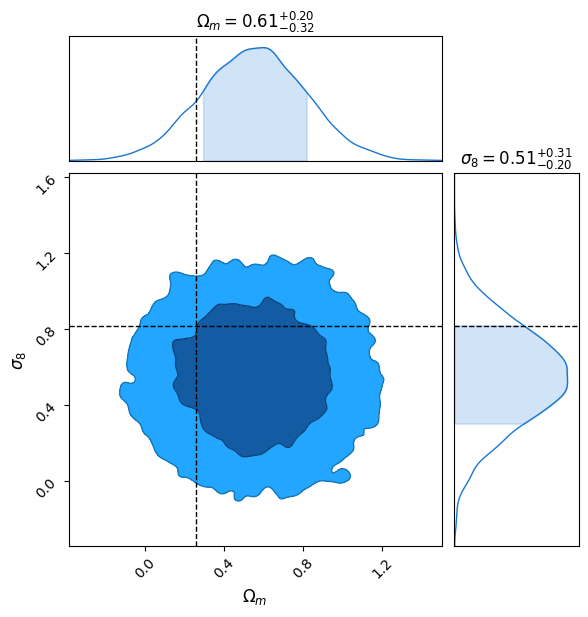

In [19]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples = model.sample(
    mu.reshape((-1, 20)), num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [20]:
log_prob = model.log_prob(samples, mu.reshape((-1, 20))*jnp.ones((10000, 1)))

In [21]:
-jnp.mean(log_prob)

Array(0.13402197, dtype=float32)

In [178]:
optimizer = optax.adam(learning_rate=1e-3)

def loss_nll(params, mu, batch):
    return -jnp.mean(model.apply(params, mu, batch, method='log_prob'))

@jax.jit
def update(params, opt_state, mu, batch):
    loss, grads = jax.value_and_grad(loss_nll)(params, mu, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

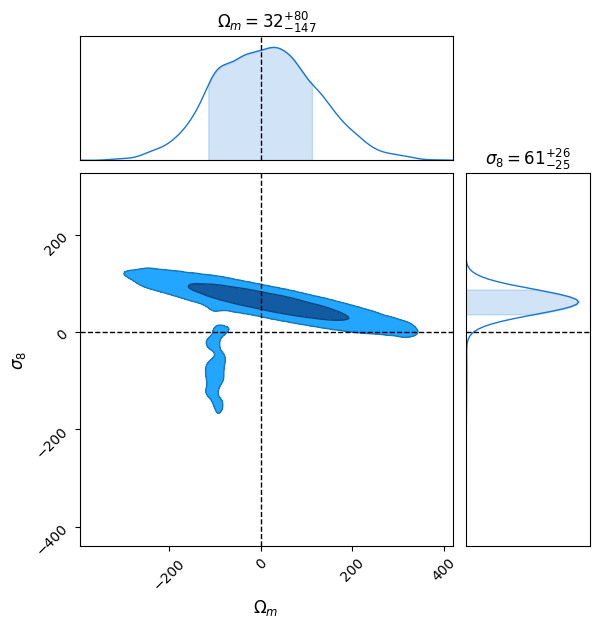

In [181]:
model = MixtureDensityNetwork(n_data=dim_params, n_components=4, layers=[50, 50], activation='silu')

params = model.init(jax.random.PRNGKey(0), *next(iter(train_loader)), method='log_prob')

samples = model.apply(
    params, mu.reshape((-1, 20)), num_samples=10000, key=jax.random.PRNGKey(0), method='sample'
)
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [ ]:
jax.nn.initializers(mu.reshape((-1, 20)), jax.random.PRNGKey(0))

In [182]:
batch_loss = []
pbar = tqdm(range(3000))

opt_state = optimizer.init(params)

for batch in pbar:
    thetas, xs = next(iter(train_loader))
    l, params, opt_state = update(
        params,
        opt_state,
        thetas, 
        xs
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")

loss 29.676: 100%|██████████| 3000/3000 [00:10<00:00, 282.86it/s]


## Same approach using SBI library

In [26]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [28]:
num_dim = 2
prior = utils.BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([1.0, 1.0]))

def simulator(parameter_set):
    return torch.from_numpy(np.asarray(sample_likelihood(parameter_set.cpu().detach().numpy().squeeze(), next(seq))))

In [27]:
%timeit simulator(prior.sample((1,)))

82.5 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
posterior = infer(simulator, prior, method='SNPE', num_simulations=5000)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 110 epochs.

In [32]:
observation = sample_likelihood(fiducial_params, jax.random.PRNGKey(0))

In [191]:
samples = posterior.sample((10000,), x=torch.tensor(np.asarray(observation)))
log_probability = posterior.log_prob(samples, x=torch.tensor(np.asarray(observation)))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

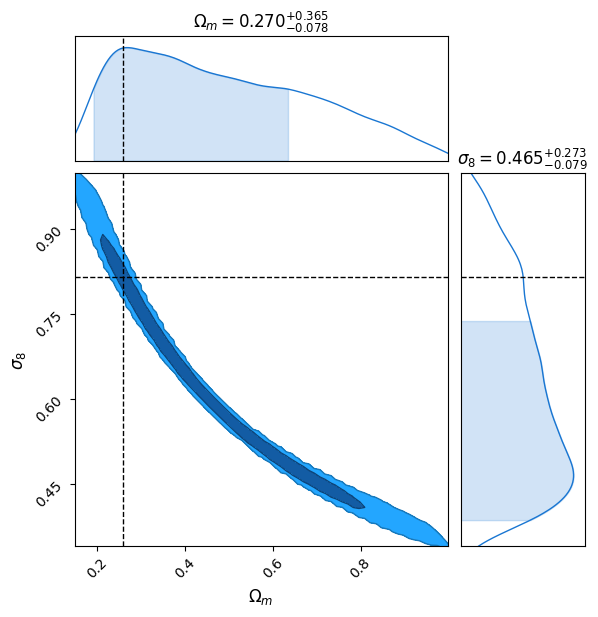

In [192]:
c = ChainConsumer()
c.add_chain(samples.cpu().detach().numpy(), parameters=[r"$\Omega_m$", r"$\sigma_8$"], kde=0.5)
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [195]:
torch.mean(log_probability)

tensor(3.8994)

In [194]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [48]:
from sbi.inference import SNPE_A, SNPE_B, SNPE_C

train_set.thetas = np.array(train_set.thetas, dtype=np.float32)

inference = SNPE_C(prior=prior)
density_estimator = inference.append_simulations(torch.tensor(train_set.thetas), torch.tensor(train_set.xs)).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 194 epochs.

In [49]:
density_estimator

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
          (context_layer): Linear(in_features=20, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=50, out_features=4, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
          (context_layer): Linear(in_features=20, out_features=50, bias=True)
          (blocks): ModuleList(
     

In [50]:
samples = posterior.sample((10000,), x=torch.tensor(np.asarray(observation)))
log_probability = posterior.log_prob(samples, x=torch.tensor(np.asarray(observation)))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
-torch.mean(log_probability)

tensor(-4.1576)

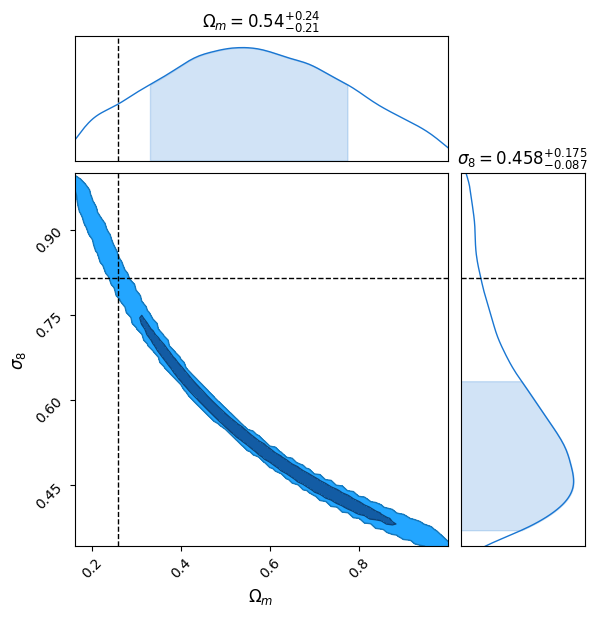

In [52]:
c = ChainConsumer()
c.add_chain(samples.cpu().detach().numpy(), parameters=[r"$\Omega_m$", r"$\sigma_8$"], kde=0.5)
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

## Kindergarten simulator

In [247]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), high=2*torch.ones(num_dim))

def simulator(parameter_set):
    return (1.0+parameter_set+np.random.randn(parameter_set.numpy().shape[1])*0.1).numpy()

In [258]:
class SimulatorDataset(data.Dataset):
    def __init__(self, num_data):
        self.thetas = prior.sample((num_data,))
        self.xs = simulator(self.thetas)
        self.thetas = self.thetas.numpy()

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [259]:
train_set_size = 5000
val_set_size = 1000
test_set_size = 2000

#Create the datasets
train_set = SimulatorDataset(train_set_size)
print("Train_set created")
val_set = SimulatorDataset(val_set_size)
print("Val_set created")
test_set = SimulatorDataset(test_set_size)
print("Test_set created")

#Specify the batch_size
batch_size = 128
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = 128
)


Train_set created
Val_set created
Test_set created


In [1]:
print(train_set.thetas[1], train_set.xs[1])

NameError: name 'train_set' is not defined

In [283]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/'

dim_params = 3
dim_obs = 20

trainer = RealNVPTrainer(n_in=dim_params,
                         n_layers=2,
                        layers=[50, 50],
                        activation = 'relu',
                        optimizer_hparams={'lr': 5e-4},
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)),
                        check_val_every_epoch=5,
                        seed=0)

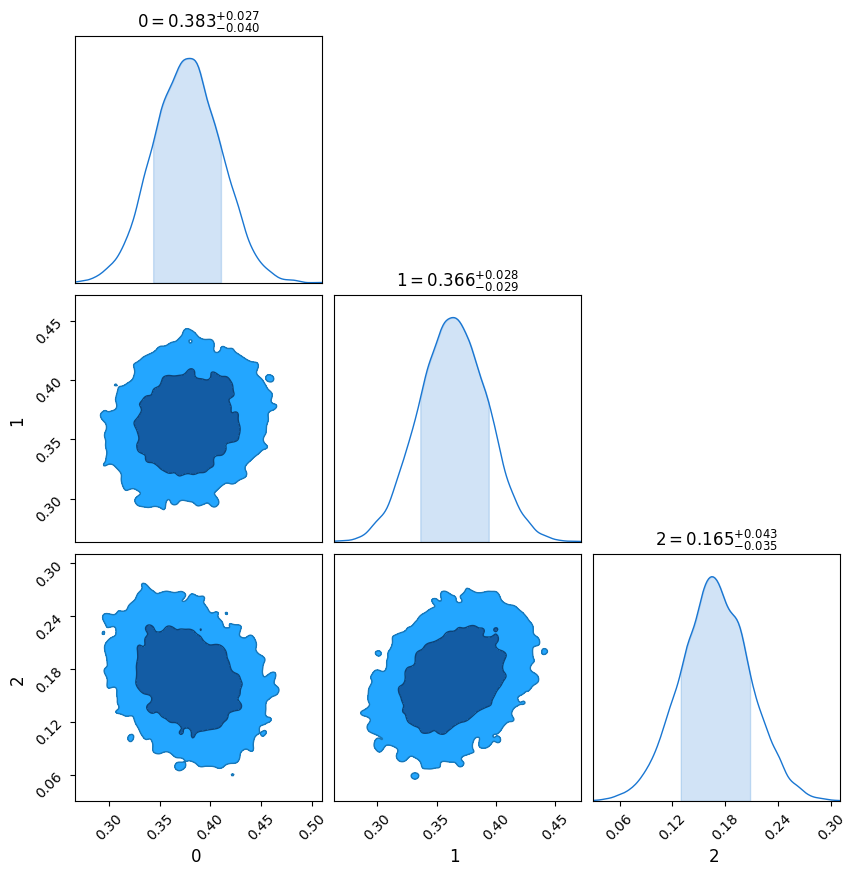

In [284]:
obs = np.zeros(3)

#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, obs.reshape((-1, 3)), num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples)
fig = c.plotter.plot(figsize=2.)
plt.show()

In [285]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5.orbax-checkpoint-tmp-1709307137029963 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5`.


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/39 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_6/checkpoint_5.


Neural network training stopped after 110 epochs.
Early stopping with best validation metric: 0.4165900945663452
Best model saved at epoch 5
Early stopping parameters: min_delta=0.001, patience=20


done


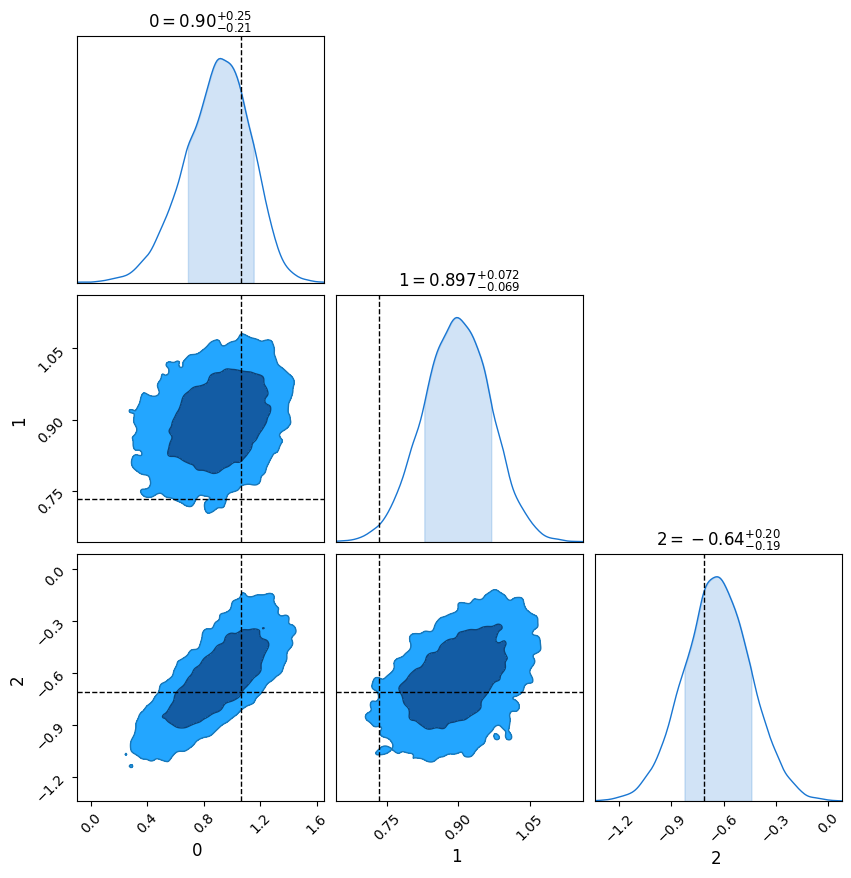

In [290]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples = model.sample(
    val_set.xs[877].reshape((-1, 3)), num_samples=10000, key=key
)
print('done')

c = ChainConsumer()
c.add_chain(samples)
fig = c.plotter.plot(figsize=2., truth=val_set.thetas[877])
plt.show()

In [294]:
jnp.mean(model.log_prob(samples, val_set.xs[877].reshape((-1, 3))*jnp.ones((10000, 1))))

Array(2.0968652, dtype=float32)

In [297]:
jnp.sum(model.log_prob(val_set.thetas, val_set.xs))/1000

Array(-0.4165901, dtype=float32)

In [144]:
(train_set.xs-np.mean(train_set.xs))/np.sqrt(np.var(train_set.xs))

array([[ 0.16259865, -0.05490405, -0.15253873, ..., -0.4572601 ,
        -0.46065858, -0.46557972],
       [ 2.5598485 ,  2.1795828 ,  1.7258956 , ..., -0.3695064 ,
        -0.3893521 , -0.40794244],
       [ 1.0174507 ,  0.7024523 ,  0.42823553, ..., -0.42099324,
        -0.43029433, -0.43892032],
       ...,
       [ 0.7539349 ,  0.6545505 ,  0.4920569 , ..., -0.4177024 ,
        -0.42959285, -0.4371011 ],
       [-0.06482892,  0.02176665, -0.11199453, ..., -0.46208364,
        -0.46170306, -0.4648518 ],
       [-0.05492363, -0.33860767, -0.33925173, ..., -0.46689558,
        -0.46942726, -0.47179618]], dtype=float32)